In [16]:
import pandas as pd,numpy as np, datetime, os,glob,tqdm,matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [45]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [85]:
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
from influxdb import DataFrameClient
host = 'localhost'
port = '8086'
user = 'mobility'
password = 'mobility!'
#dbname = 'mydb'
dbname = 'Caltrans_Loop_Detectors_Raw_Data_D7'
protocol = 'line'
client = DataFrameClient(host, port, user, password, dbname)
client.switch_database(dbname)

# This cell runs on helix and extracts data from InfluxDB

In [ ]:
i = 767470
response = client.query("select (LOOP_1_FLOW) from raw_D7 where VDS_ID = '%d' AND time >= '2019-11-25T00:00:00Z' AND time <= '2019-12-01T23:59:30Z'" % i)

### Making a dataframe
if response:
    ytrain = pd.DataFrame.from_dict(response['raw_D7'])

### Aggregating for 10 minutes
ytrain['count'] = 1
ytrain = ytrain.resample('10T', how = sum)
ytrain['load_date'] = ytrain.index

ytrain.to_csv('Unsupervised_Anomaly_Input.csv')

In [63]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important


In [68]:
df = pd.read_csv('Unsupervised_Anomaly_Input.csv')
del df['Unnamed: 0']
del df['LOOP_1_FLOW']
df.columns = ['value','timestamp']
print(df.shape)
df.head()

(1008, 2)


,value,timestamp
0,16,2019-11-25 00:00:00+00:00
1,16,2019-11-25 00:10:00+00:00
2,15,2019-11-25 00:20:00+00:00
3,19,2019-11-25 00:30:00+00:00
4,17,2019-11-25 00:40:00+00:00


In [69]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,value,timestamp
0,16,2019-11-25 00:00:00+00:00
1,16,2019-11-25 00:10:00+00:00
2,15,2019-11-25 00:20:00+00:00
3,19,2019-11-25 00:30:00+00:00
4,17,2019-11-25 00:40:00+00:00


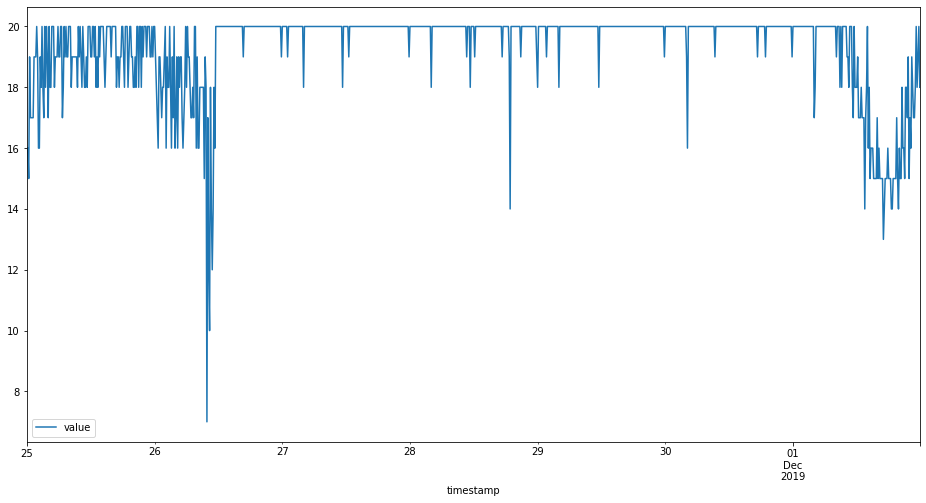

In [70]:
df.plot(x='timestamp', y='value',figsize=(16,8))

In [75]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df.head()

,value,timestamp,hours,daylight,DayOfTheWeek,WeekDay,time_epoch
0,16,2019-11-25 00:00:00+00:00,0,0,0,1,15746400
1,16,2019-11-25 00:10:00+00:00,0,0,0,1,15746406
2,15,2019-11-25 00:20:00+00:00,0,0,0,1,15746412
3,19,2019-11-25 00:30:00+00:00,0,0,0,1,15746418
4,17,2019-11-25 00:40:00+00:00,0,0,0,1,15746424


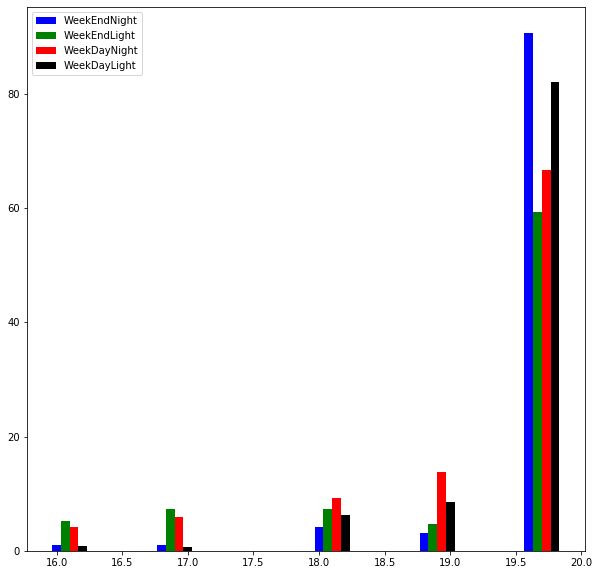

In [91]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig = plt.figure(figsize=(10,10))
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

plt.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
plt.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
plt.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
plt.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [83]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [102]:
data.head()

,0,1
0,-0.840537,1.516432
1,-0.840537,1.516432
2,-0.744847,1.480694
3,-1.127607,1.623646
4,-0.936227,1.552170


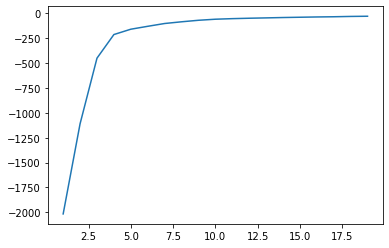

In [86]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [87]:
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

4     84
2     84
7     82
10    81
12    78
8     77
13    72
14    69
3     67
1     65
5     55
9     53
11    48
0     48
6     45
Name: cluster, dtype: int64

In [104]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis


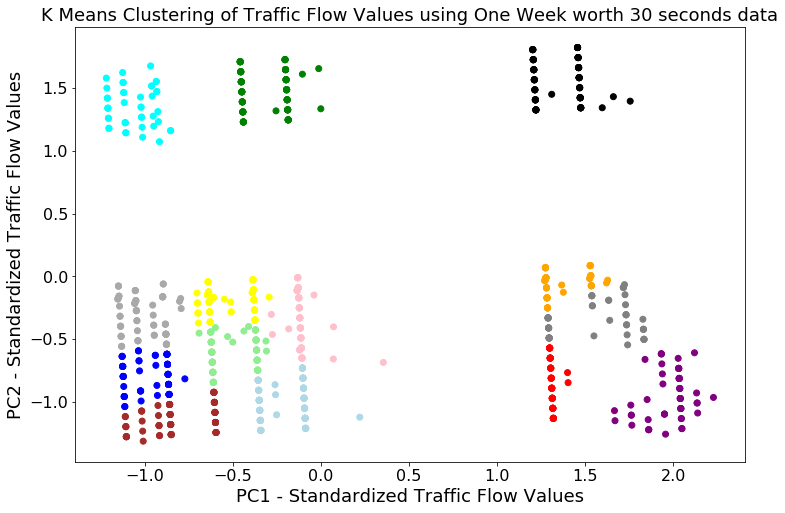

In [120]:
fig = plt.figure(figsize=(12,8))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
plt.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.title('K Means Clustering of Traffic Flow Values using One Week worth 30 seconds data',fontsize =18)
plt.xlabel('PC1 - Standardized Traffic Flow Values',fontsize = 18)
plt.ylabel('PC2 - Standardized Traffic Flow Values',fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Clustering the Principal Features.png')
plt.show()

In [95]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly
outliers_fraction = 0.01

In [96]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


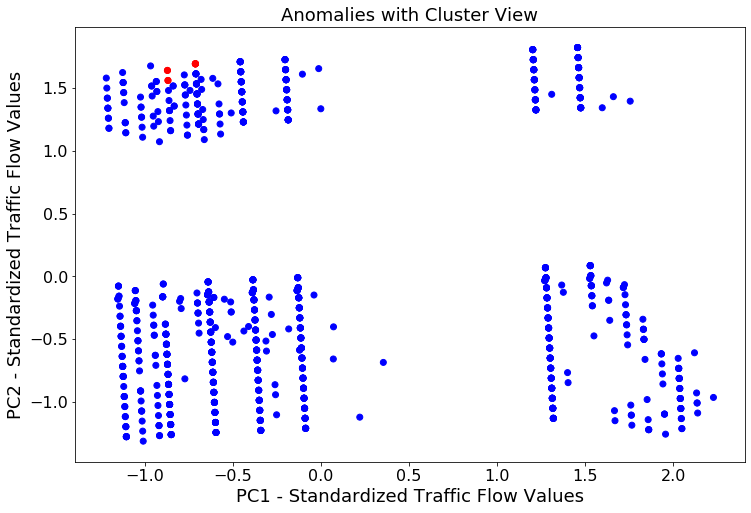

In [121]:
# visualisation of anomaly with cluster view
fig = plt.figure(figsize=(12,8))
colors = {0:'blue', 1:'red'}
plt.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.title('Anomalies with Cluster View',fontsize =18)
plt.xlabel('PC1 - Standardized Traffic Flow Values',fontsize = 18)
plt.ylabel('PC2 - Standardized Traffic Flow Values',fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('anomaly_cluster.png')
plt.show()

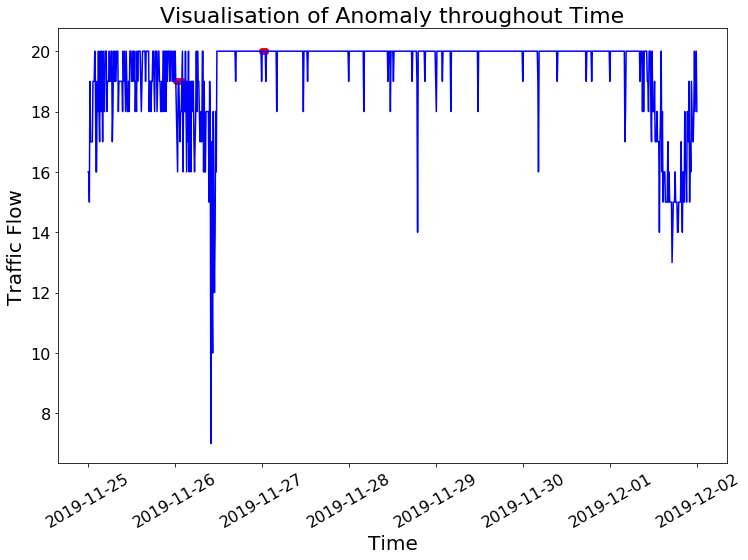

In [131]:
fig = plt.figure(figsize=(12,8))
a = df.loc[df['anomaly21'] == 1, ['timestamp', 'value']] #anomaly

plt.plot(df['timestamp'], df['value'], color='blue')
plt.scatter(a['timestamp'],a['value'], color='red')
plt.title('Visualisation of Anomaly throughout Time',fontsize =22)
plt.xlabel('Time',fontsize = 20)
plt.ylabel('Traffic Flow',fontsize = 20)
plt.xticks(rotation = 30,fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Anomaly_in_time.png',bbox_inches = 'tight')
plt.show()